<a href="https://colab.research.google.com/github/zakirovde/netology_dz/blob/master/HW1_banki_TM_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pymorphy2

In [0]:
import json
import bz2
import regex
from tqdm.notebook import tqdm
tqdm.pandas()
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import toktok
toktok = toktok.ToktokTokenizer()
%matplotlib inline
%pylab inline
from sklearn.metrics import precision_score, recall_score, \
  f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from pymorphy2 import MorphAnalyzer
pm2 = MorphAnalyzer()
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from gensim.models import  *
from gensim import similarities
from gensim.corpora import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import *
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import ldamodel
from gensim.models import lsimodel
from gensim import similarities

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf', 'deprecated']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [0]:
df = pd.DataFrame({'bank': [], 'city': [], 'rating': [], 'text': [], 'title': []})
with bz2.BZ2File('/content/drive/My Drive/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            df_mrg = pd.DataFrame({'bank': [resp['bank_name']], 
                         'city': [resp['city']], 
                         'rating': [resp['rating_grade'] or 0], 
                         'text': [resp['text']], 
                         'title': [resp['title']]})
            df = pd.concat([df, df_mrg])

In [0]:
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text):
    try:
        lem = [pm2.parse(word)[0].normal_form for word in text.split()]
        return " ".join(lem).strip()  
    except:
        return ""
    
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

def full_prep(text):
    text = text.lower()
    return remove_stoplemmas(remove_stopwords(words_only(lemmatize(text))))

# df['text_prep'] = df.text.progress_apply(full_prep)

In [0]:
df.to_csv('/content/drive/My Drive/banki_responses.csv', index=False)

In [0]:
df = pd.read_csv('/content/drive/My Drive/banki_responses.csv')

In [0]:
df.text_prep = df.text_prep.fillna('')

### Количество отзывов на разные города и банки

In [0]:
df_city_bank = df.groupby(['city', 'bank']).size().rename('count').sort_values(ascending=False).reset_index()
df_city_bank.head()

,city,bank,count
0,г. Москва,Сбербанк России,8146
1,г. Москва,Альфа-Банк,3871
2,г. Москва,Русский Стандарт,2801
3,г. Москва,ВТБ 24,2714
4,г. Санкт-Петербург,Сбербанк России,2434


### Длина текстов в символах

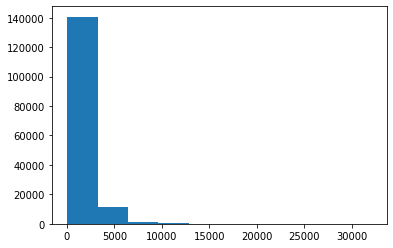

In [0]:
text_len = df.text.apply(len)

fig, ax = plt.subplots()
lng = text_len.tolist()
n, bins, patches = ax.hist(lng)
plt.show()

### Длина текстов в словах

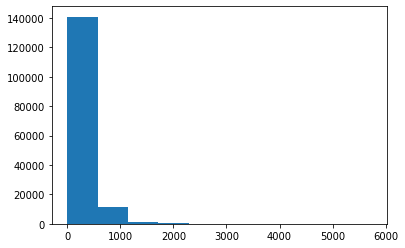

In [0]:
words_len = df.text.progress_apply(toktok.tokenize).progress_apply(len)

fig, ax = plt.subplots()
lng = words_len.tolist()
n, bins, patches = ax.hist(lng)
plt.show()

### 10 самых...

In [0]:
stops = stopwords.words('russian')

cnt_tokens, cnt_wo_stops, cnt_lemmas, cnt_nouns = \
    Counter(), Counter(), Counter(), Counter()
n_types, n_tokens = [], []

for index, row in tqdm(df.iterrows(), total = len(df)):

    tokens = row['text'].lower().split()
    cnt_tokens.update(tokens)
    n_types.append(len(cnt_tokens))
    n_tokens.append(sum(list(cnt_tokens.values())))

    tokens_wo = [t for t in tokens if not t in stops]
    cnt_wo_stops.update(tokens_wo)
   
    lemmas = [pm2.parse(word)[0].normal_form for word in tokens_wo]
    cnt_lemmas.update(lemmas)
  
    nouns = [t for t in tokens if 'NOUN' in pm2.parse(t)[0].tag]
    cnt_nouns.update(nouns)

### 10 самых частых слов

In [0]:
for i in cnt_tokens.most_common(10):
    print(i)

('в', 1308201)
('и', 1036679)
('не', 841941)
('на', 696880)
('что', 603955)
('я', 549713)
('с', 449286)
('по', 358723)
('мне', 302747)
('-', 294086)


### 10 самых частых слов без стоп-слов

In [0]:
for i in cnt_wo_stops.most_common(10):
    print(i)

('-', 294086)
('это', 171582)
('банка', 160550)
('банк', 134069)
('деньги', 96154)
('карту', 66651)
('карты', 64616)
('очень', 64613)
('заявление', 53267)
('кредит', 53104)


### 10 самых частых лемм без стоп-слов

In [0]:
for i in cnt_lemmas.most_common(10):
    print(i)

('-', 294086)
('банка', 231913)
('карта', 219718)
('это', 196558)
('банк', 163767)
('мой', 157578)
('который', 142638)
('деньга', 128634)
('отделение', 109285)
('сотрудник', 109248)


### 10 самых частых существительных

In [0]:
for i in cnt_nouns.most_common(10):
    print(i)

('банка', 160550)
('банк', 134069)
('деньги', 96154)
('карту', 66651)
('карты', 64616)
('раз', 61852)
('заявление', 53267)
('кредит', 53104)
('отделение', 50251)
('время', 49853)


### Закон Ципфа

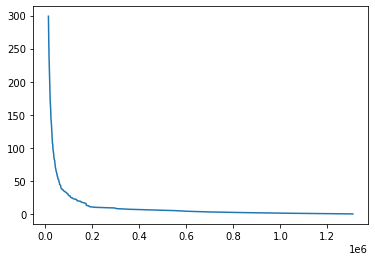

In [0]:
freqs = list(cnt_tokens.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

### Закон Хипса

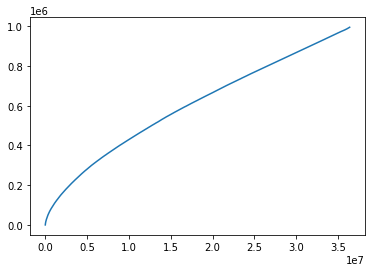

In [0]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

In [0]:
print('Слово "сотрудник" встречается {}, а "клиент" -- {} раз.'.format(cnt_lemmas['сотрудник'], cnt_lemmas['клиент']))
print('Слова "мошенничество" и "доверие" встречаются {} и {} раза соответственно.'.
      format(cnt_lemmas['мошенничество'], cnt_lemmas['доверие']))

Слово "сотрудник" встречается 109248, а "клиент" -- 81409 раз.
Слова "мошенничество" и "доверие" встречаются 1429 и 1440 раза соответственно.


### Топ ключевых слов и биграмм в отрицательных отзывах

In [0]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(df.loc[df.rating==1]['text'])])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,не
1,на
2,что
3,по
4,мне
5,банка
6,банк
7,как
8,то
9,меня


### Топ ключевых слов и биграмм в положительных отзывах

In [0]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(df.loc[df.rating==5]['text'])])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,не
1,на
2,что
3,по
4,банка
5,все
6,за
7,мне
8,но
9,как



## Часть 2. Тематическое моделирование [20/100]
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [0]:
texts = [text.split() for text in df.text_prep]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)
corpus = [dictionary.doc2bow(text) for text in texts]

In [0]:
lsi.print_topics(30)

[(0,
  '0.170*"карта" + 0.125*"кредит" + 0.112*"заявление" + 0.109*"деньга" + 0.100*"сч" + 0.100*"отделение" + 0.097*"сумма" + 0.095*"кредитный" + 0.094*"банкомат" + 0.091*"сотрудник"'),
 (1,
  '0.367*"кредит" + -0.262*"банкомат" + -0.213*"вклад" + -0.209*"карта" + -0.151*"деньга" + 0.140*"погашение" + 0.131*"договор" + 0.129*"задолженность" + 0.122*"страховка" + 0.121*"кредитный"'),
 (2,
  '-0.500*"вклад" + 0.207*"банкомат" + 0.146*"сбербанк" + 0.145*"заявление" + 0.135*"карта" + -0.133*"открыть" + -0.128*"очередь" + 0.106*"руб" + 0.106*"средство" + -0.104*"вклада"'),
 (3,
  '-0.283*"вклад" + 0.234*"номер" + -0.221*"сумма" + -0.202*"руб" + 0.160*"звонок" + -0.153*"договор" + -0.151*"погашение" + -0.142*"досрочный" + 0.136*"телефон" + 0.128*"заявка"'),
 (4,
  '0.345*"вклад" + 0.254*"номер" + -0.195*"кредит" + -0.173*"банкомат" + -0.150*"заявка" + 0.149*"звонок" + -0.140*"карта" + 0.140*"ваш" + 0.138*"денежный" + 0.119*"телефон"'),
 (5,
  '0.418*"банкомат" + -0.390*"карта" + -0.182*"кре

In [0]:
lda = ldamodel.LdaModel(corpus, num_topics=30, id2word=dictionary, passes=15)

In [0]:
lda.print_topics(30)

[(0,
  '0.046*"весь" + 0.023*"банк" + 0.019*"очень" + 0.015*"год" + 0.013*"ещ" + 0.009*"просто" + 0.009*"хороший" + 0.009*"большой" + 0.008*"самый" + 0.007*"пользоваться"'),
 (1,
  '0.049*"го" + 0.027*"дата" + 0.022*"число" + 0.020*"пожалуйста" + 0.017*"администратора" + 0.012*"декабрь" + 0.011*"январь" + 0.010*"числа" + 0.010*"января" + 0.009*"декабря"'),
 (2,
  '0.029*"банк" + 0.015*"рф" + 0.013*"денежный" + 0.012*"средство" + 0.012*"г" + 0.012*"право" + 0.012*"договор" + 0.011*"банковский" + 0.009*"закон" + 0.008*"суд"'),
 (3,
  '0.039*"отделение" + 0.034*"очередь" + 0.023*"работать" + 0.022*"офис" + 0.018*"время" + 0.016*"минута" + 0.013*"касса" + 0.012*"человек" + 0.011*"работа" + 0.010*"клиент"'),
 (4,
  '0.034*"банка" + 0.028*"номер" + 0.028*"телефон" + 0.027*"звонок" + 0.025*"ваш" + 0.019*"звонить" + 0.013*"сотрудник" + 0.011*"банк" + 0.010*"дать" + 0.009*"кредит"'),
 (5,
  '0.171*"сч" + 0.029*"счета" + 0.028*"счет" + 0.024*"деньга" + 0.023*"открыть" + 0.021*"открытие" + 0.018*

Так если посмотреть, то складывается ощущение, будто основные проблемы -- это комиссия. А также кредитные лимиты. Хоть есть название банка, хоть нет. Но имеено со Сбером часто попадается страховка. Также касательно конкретных банков люди упоминают мобильный банкинг.

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [0]:
df1 = df[df.rating==1][:10000]
df5 = df[df.rating==5][:40000]
df_15 = pd.concat([df1, df5])
df_15['label'] = df_15['rating'].apply(lambda x: 1 if x==1 else 0)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_15['text_prep'], df_15['label'])

In [0]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('clf', RandomForestClassifier()),
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range={4, 6}, preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

Precision:   0.92
Recall:   0.91
F1-measure:   0.92
Accuracy:   0.92
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3630
           1       0.94      0.87      0.90      2549

    accuracy                           0.92      6179
   macro avg       0.92      0.91      0.92      6179
weighted avg       0.92      0.92      0.92      6179



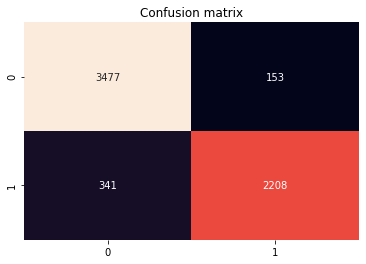

In [0]:
predictions = clf.predict(X_test)

print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [0]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={1,3})),
    ('clf', RandomForestClassifier()),
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range={1, 3}, preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

Precision:   0.91
Recall:   0.89
F1-measure:   0.90
Accuracy:   0.90
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3630
           1       0.93      0.83      0.88      2549

    accuracy                           0.90      6179
   macro avg       0.91      0.89      0.90      6179
weighted avg       0.90      0.90      0.90      6179



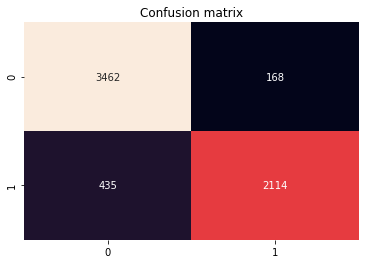

In [0]:
predictions = clf.predict(X_test)

print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [0]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1,3))), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

Precision:   0.87
Recall:   0.87
F1-measure:   0.87
Accuracy:   0.88
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      3630
           1       0.86      0.84      0.85      2549

    accuracy                           0.88      6179
   macro avg       0.87      0.87      0.87      6179
weighted avg       0.88      0.88      0.88      6179



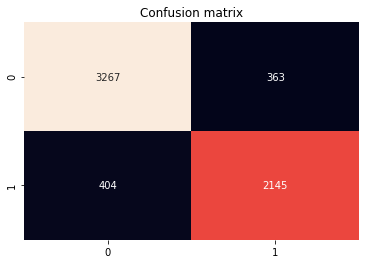

In [0]:
predictions = clf.predict(X_test)

print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()